# PPRS: Week 11
# Spatial data analysis and batch processing in Python

In [1]:
# run this to display graphs nicely in this notebook

%matplotlib inline


## Introduction

This week we will use python to process a large set of data. GIS allows us to visually assess and interact with each step, whilst python allows us to easily scale up to processing large datasets with a single button press, making repeat processing easy. This follows on from the introduction to lidar session and is meant as an introduction to OOSA. We will use lidar data to map biomass along the Spey river valley.

Tasks for you to complete are written in **bold font**.


## Data

We are using the DTM and DSM provided by the [Scottish government](https://remotesensingdata.gov.scot/data#/list). These were collected as point clouds and then processed to a DTM and DSM in geotiff format. After cloning these will be in the ***data*** directory. The raw data comes in 1 m resolution but the ALS point density was a little too low to support that, so we have coarsened it first to 3 m, taking the mean elevation for the DTM and the maximum elevation for the DSM, and then to 10 m taking the mean for both. Due to disk space limits on noteable, the data has already been coarsened for you.

The 10 m resolution DTM and DSMs are available in the folders below, in geotiff raster format:

    data/ALS/DTM
    data/ALS/DSM

Later on a python cell will be given to show you how that coarsening was done, and a single full-res DSM file has been provided in in case you want to run this process from first principles. Note that you can install Python on your own laptop, or use it on the University's Windows or Linux computers, where you will get access to move more disk space.


You can download some of these tiles to your computer and view them in QGIS if you would like. Or you can use some of the plotting functions within python to view them here.

This week we will use the rasterio package to open our data. Below you will see code which uses this module and its functions to open and read GeoTIFF files. Note that *there are many many many Python modules out there, some with overlapping functionality.* The [manual](https://rasterio.readthedocs.io/en/stable/) shows the many options available.

 ote that our geotiff has some missing data, labelled as -999. We can filter out to allow you to calculate metrics on the data only using the *not a number* variable, *nan*.

In [2]:
# read in the necessary packages
import numpy as np
from sys import exit
import rasterio


# set a filename
filename='data/ALS/DSM_1m/NN89_1M_DSM_PHASE1.tif'

# read the data into a rasterio object
datafile=rasterio.open(filename)

# read the first band
data=datafile.read(1)

# label missing data as nan
data[data<0.0] = np.nan

# read the geolocation meta data
# note that the rasterio object contains many more variables. See the manual
res=datafile.res
nX=datafile.width
nY=datafile.height

# let us pring some of these to screen to see them
print('x resolution',round(res[0],2),'m. y resolution',round(res[1],2),'m')
print('The raster has',nX,'by',nY,'pixels')

x resolution 1.0 m. y resolution 1.0 m
The raster has 1000 by 1000 pixels


Now our data is in RAM, we can manipulate it in anyway we like. We can use the numpy functions to calculate some summary statistics of the data, as below.

**Add some lines to the end of the cell to calculate and print the minimum and maximum elevation for this tile, using the np.min() and np.max() functions.**

You can use the "round(x,2)" function to output to a sensible degree of precision. Before calculating the statistics we remove the missing data values (nan). Note that this new "usableData" array will not be a rectangle so cannot be displayed as an image anymore.

In [3]:
# remove missing data
usableData=data[np.isnan(data)==False]

# mean elevation
meanElev=np.mean(usableData)
print('Mean elevation is',round(meanElev,2),'m')

# some measure of roughness
stdevElev=np.std(usableData)
print('The standard deviation of elevation is',round(stdevElev,2),'m')

# calculate and print the min and max elevation
minElev=np.min(usableData)
maxElev=np.max(usableData)

print('Min',minElev,'m. max',maxElev,'m')


Mean elevation is 294.4 m
The standard deviation of elevation is 13.08 m
Min 261.56 m. max 337.94 m


## Image maps

It is very useful to be able to plot images of our data to quicly asses it and check for artefacts. Simply calling `plt.imshow(data)` will now make an image map. This is part of the same package we used to plot data in the last notebook, but is set up for making 2D images.


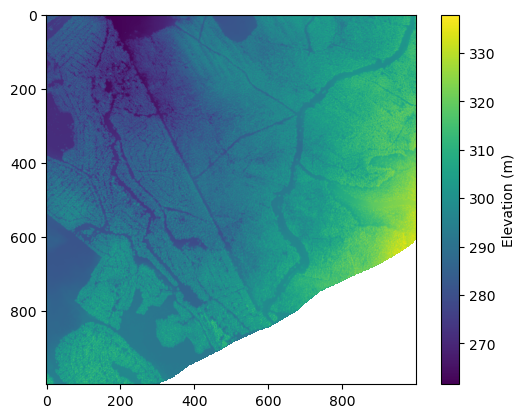

In [4]:
import matplotlib.pyplot as plt

# plot the 2D raster layer  
plt.imshow(data)   # plot the 2D image
plt.colorbar(label='Elevation (m)')     # add a colour bar
plt.show()         # print to screen 



## ***Optional:*** Pre-processing data

This part is included for your own interest. You can skip to the "Mapping biomass" part if you like. The data has already been processed to a 10 m resolution DTM and DSM ready for you to use to map biomass. This is included here if you would like to see how to process the data from first principles, but it goes in to the fine details of the geolocation information within the raster file.

If you visually inspect the 1 m resolution DSM (eg in QGIS), you will notice stripes between the lidar scan lines, due to the DSM being produced at too high a resolution. We need to coarsen the DSM to around 3 m resolution, taking the maximum so that the false zero pixels do not bias the canopy height. This can be done with the script below.

In [5]:
# This is taken from:
# https://gis.stackexchange.com/questions/110769/gdal-python-aggregate-raster-into-lower-resolution

# libraries needed to handle the data
from osgeo import gdal,osr


def coarsenRaster(filename,outRes,outName,mode='max'):
    '''Coarsen the resolution of a raster and write to file'''

    inDS=gdal.Open(filename)


    # reproject that data to a coarser resolution
    # first read the geolocation information, which includes the resolution
    outGeo=list(inDS.GetGeoTransform())  # puts the geolocation information in to a python list

    # read each element of the list in to variables we can use to rescale
    x0=outGeo[0]   # the x corner
    xRes=outGeo[1] # x resolution
    i0=outGeo[2]   # x pixel number of the corner, normally 0
    y0=outGeo[3]   # the y corner
    j0=outGeo[4]   # y pixel number of the corner, normally 0
    yRes=outGeo[5] # y resolution
    nX=inDS.RasterXSize  # number of x pixels
    ny=inDS.RasterYSize  # number of y pixels

    # coarsen the above by the factor you want
    outNx=int(nX*xRes/outRes)  # number of x pixels in the output
    outNy=int(nY*abs(yRes)/outRes)  # number of y pixels in the output. Abs makes the negative positive
    outXres=outRes
    outYres=-1*outRes
    
    # load the new geoloction information in to a python tuple
    OutGT = tuple([x0,outXres,i0,j0,y0,outYres])
    
    # set up a new geotiff dataset
    OutDriver = gdal.GetDriverByName('GTiff')

    # load the geolocation in to the new file
    outDS = OutDriver.Create(outName,outNx,outNy,1,gdal.GDT_Float32 )
    outDS.SetGeoTransform(OutGT)
    outDS.SetProjection(inDS.GetProjection()) # copy projection info

    # read the data
    inData=inDS.GetRasterBand(1).ReadAsArray(0,0,nX,nY)
    
    # coarsen it
    outData=np.zeros((outNx,outNy),dtype=float)
    xWindow=int(outXres/xRes)/2
    yWindow=int(outYres/yRes)/2
    nXratio=nX/outNx
    nYratio=nY/outNy
    
    # loop over the x and y pixels of the coarse image and read the original image pixels
    for i in range(0,outNx):
        
        # set x slicing bounds
        minI=int(i*nXratio-xWindow)
        if(minI<0):
            minI=0
        maxI=int(i*nXratio+xWindow+1)
        if(maxI>=nX):
            maxI=nX-1
            
        for j in range(0,outNy):
            
            # set slicing bounds
            minJ=int(j*nYratio-yWindow)
            if(minJ<0):
                minJ=0
            maxJ=int(j*nYratio+yWindow+1)
            if(maxJ>=nY):
                maxJ=nY-1
            
            # calculate the maximum pixel within the sliced bounds
            if(mode=='max'):
                outData[i,j]=np.max(inData[minI:maxI,minJ:maxJ])
            else:
                outData[i,j]=np.mean(inData[minI:maxI,minJ:maxJ])

    # write the data to the geotiff
    outDS.GetRasterBand(1).WriteArray(outData)  # write image to the raster
    outDS.GetRasterBand(1).SetNoDataValue(0)  # set no data value
    outDS.FlushCache()                     # write to disk
    outDS = None

    # tell the user where the data has been written to
    print('New file written to',outName)
    
    
#####################################
# now call the above function
    
# define an output resolution
outRes=3   # 3 m resolution

# set an input and output filename
inName='data/ALS/DSM_1m/NN89_1M_DSM_PHASE1.tif'
outName='data/ALS/DSM_1m/NN89_3M_DSM_PHASE1.tif'

# call the above function to coarsen and write
coarsenRaster(inName,outRes,outName)

New file written to data/ALS/DSM_1m/NN89_3M_DSM_PHASE1.tif


By changing the ***np.max()*** command to ***np.mean()***, the same script can be used to coarsen both the 3 m resolution DSM we have just created and the 1 m resolution DTM to create a 10 m resolution DSM and DTM. **You can use the cell below to do that if you would like.**

In [6]:
# the function above has been modified to use an if switch

# define an output resolution
outRes=3   # 3 m resolution

# set an input and output filename
inName='data/ALS/DTM_1m/NN89_1M_DTM_PHASE1.tif'
outName='data/ALS/DTM_1m/NN89_3M_DTM_PHASE1.tif'

# call the above function to coarsen and write
coarsenRaster(inName,outRes,outName,mode='mean')

New file written to data/ALS/DTM_1m/NN89_3M_DTM_PHASE1.tif


## Mapping biomas

Now we can have some 10 m resolution DTM and DSM tiles and functions to read them in to RAM, we can to repeat the analysis from week 2 using an automatic python workflow.

### Canopy height map

The first step was to make a canopy height map which we can use to first calibrate a model between our lidar measurement and some ground biomass data, and then predict biomass across our site. To do this we need to read the DTM and DSM in to RAM as numpy arrays, filter missing data and then subtract the DTM from the DSM to make a new CHM array. This is quite a few lines of code and so we have grouped it into a "user defined function". This is a set of instructions that we can call throughout the program and allows us to write compact, reusable code.

**Add some lines to the end of this cell to plot the CHM you have just made.**

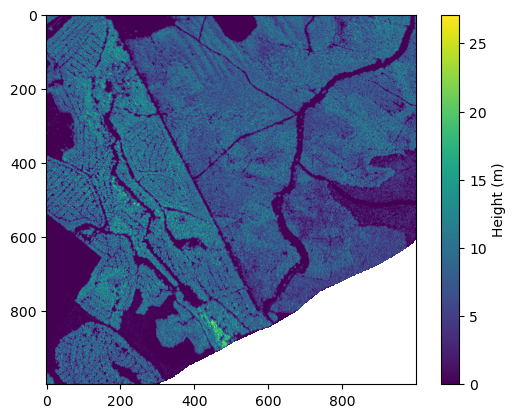

In [7]:
# make sure you have run the readTiff() cell above to load that function.

def heightAboveGround(dtmName,dsmName):
    '''
    A function to calculate height above ground from a DTM and DSM
    Note that this assumes the two datasets are aligned and the same resolution
    '''
    
    # open the DTM and DSM and read data
    dtmFile=rasterio.open(dtmName)
    dtm=dtmFile.read(1)
    dsmFile=rasterio.open(dsmName)
    dsm=dsmFile.read(1)
    

    # filter both datasets
    dtm[dtm<0.0] = np.nan
    dsm[dsm<0.0] = np.nan
    
    # Subtract the two to get height, as two are aligned
    hData=dsm-dtm
      
    # pass back to the calling function
    return(hData,dtmFile)



# define filenames to use
dsmName='data/ALS/DSM_1m/NN89_1M_DSM_PHASE1.tif'
dtmName='data/ALS/DTM_1m/NN89_1M_DTM_PHASE1.tif'


# call the user defined function to calculate the height array and metadata and read in to RAM
hData,rast=heightAboveGround(dtmName,dsmName)


# Add some lines below here to make an image of the CHM
plt.imshow(hData)
plt.colorbar(label='Height (m)')     # add a colour bar
plt.show()         # print to screen 

Now we have a function to calculate canopy height from a single DSM and DTM. We then want to process all of the data. As a first step, let us practice processing all of the data to height and making an image of each tile to see how a loop can be used to batch process.

The code below will create a list of all of the DTM and DSM filenames. **Add a loop to step through these filenames and call the ***heightAboveGround()*** function defined above to calculate height, then plot an image of each tile.**

data/ALS/DTM/coarsen.NH70_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NH70_10M_DSM_PHASE1.tif


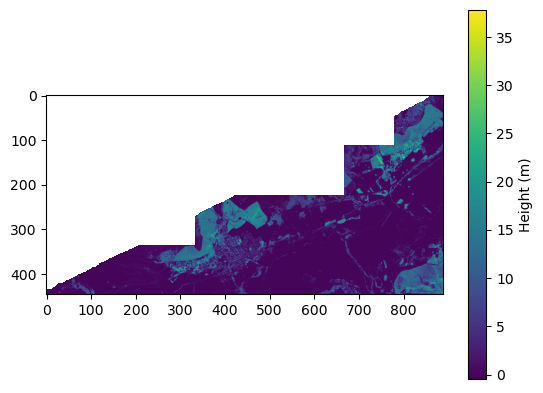

data/ALS/DTM/coarsen.NH80_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NH80_10M_DSM_PHASE1.tif


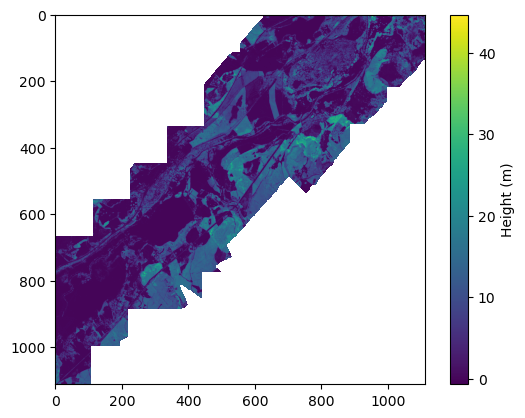

data/ALS/DTM/coarsen.NH81_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NH81_10M_DSM_PHASE1.tif


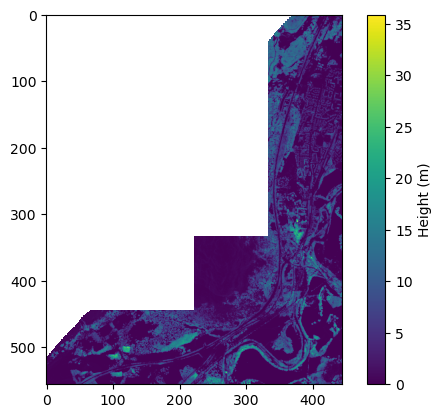

data/ALS/DTM/coarsen.NH90_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NH90_10M_DSM_PHASE1.tif


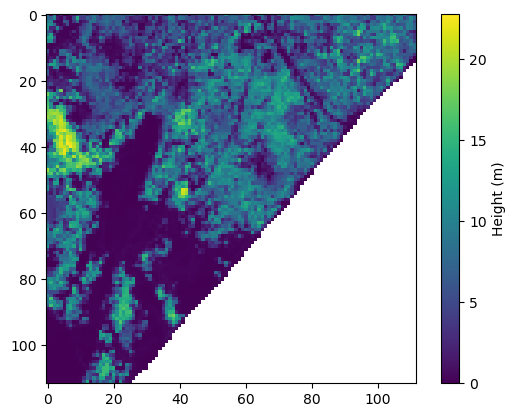

data/ALS/DTM/coarsen.NH91_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NH91_10M_DSM_PHASE1.tif


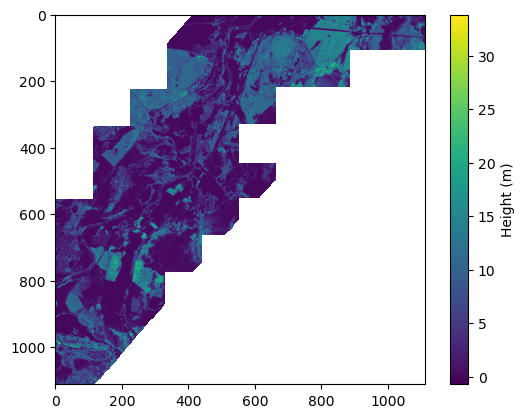

data/ALS/DTM/coarsen.NH92_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NH92_10M_DSM_PHASE1.tif


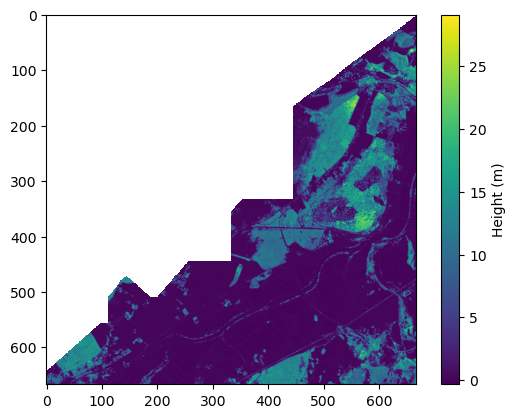

data/ALS/DTM/coarsen.NJ01_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NJ01_10M_DSM_PHASE1.tif


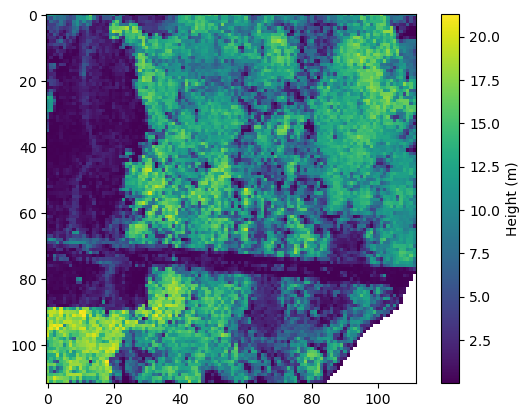

data/ALS/DTM/coarsen.NJ02_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NJ02_10M_DSM_PHASE1.tif


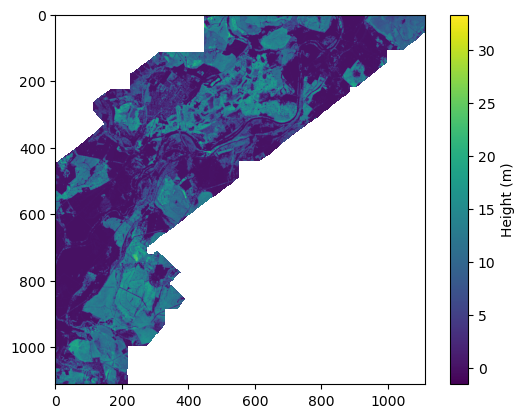

data/ALS/DTM/coarsen.NJ03_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NJ03_10M_DSM_PHASE1.tif


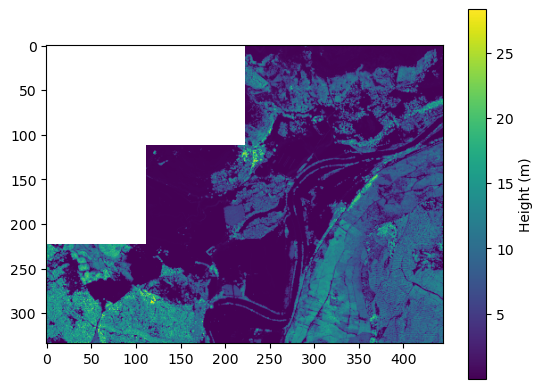

data/ALS/DTM/coarsen.NJ13_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NJ13_10M_DSM_PHASE1.tif


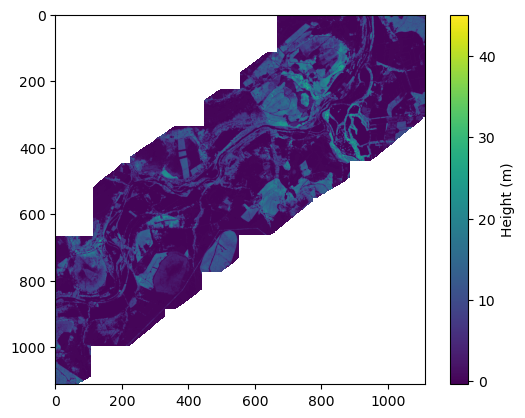

data/ALS/DTM/coarsen.NJ14_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NJ14_10M_DSM_PHASE1.tif


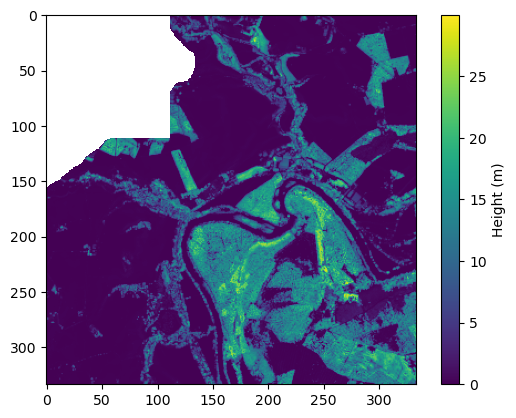

data/ALS/DTM/coarsen.NJ23_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NJ23_10M_DSM_PHASE1.tif


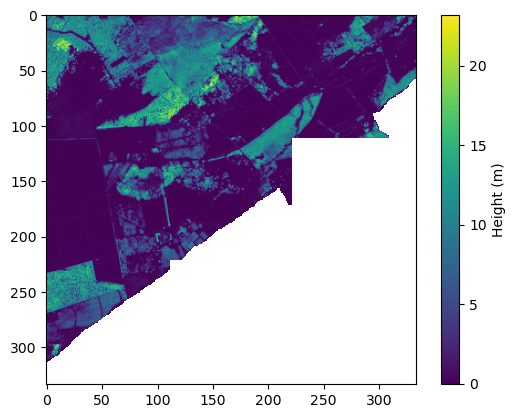

data/ALS/DTM/coarsen.NJ24_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NJ24_10M_DSM_PHASE1.tif


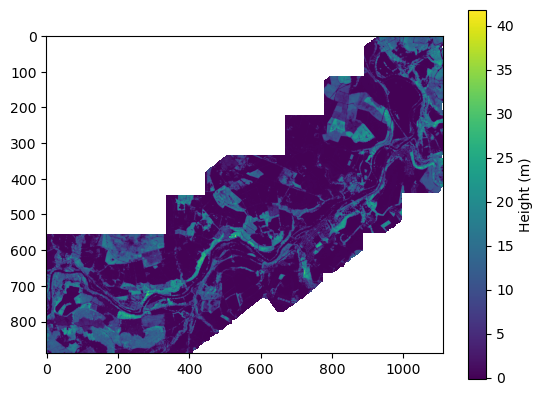

data/ALS/DTM/coarsen.NN69_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NN69_10M_DSM_PHASE1.tif


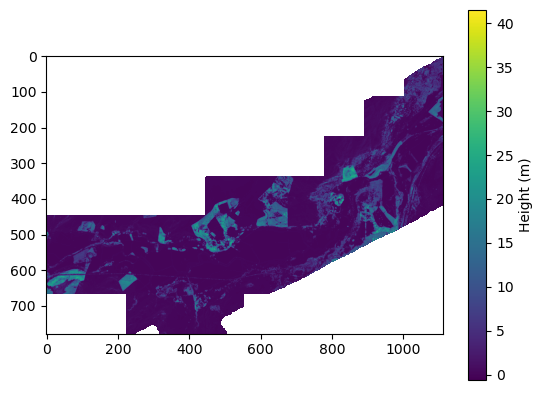

data/ALS/DTM/coarsen.NN79_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NN79_10M_DSM_PHASE1.tif


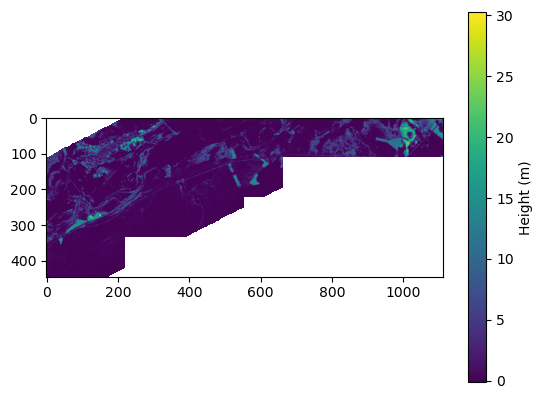

data/ALS/DTM/coarsen.NN89_10M_DTM_PHASE1.tif data/ALS/DSM/coarsen.NN89_10M_DSM_PHASE1.tif


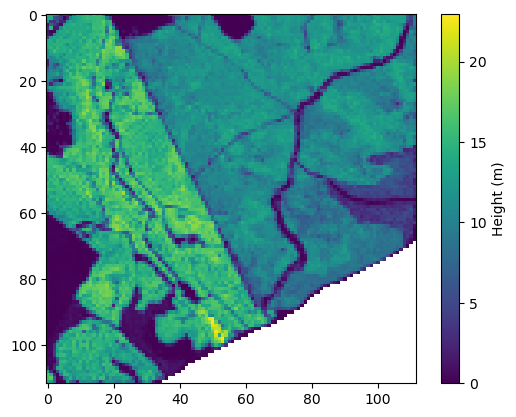

In [8]:
from glob import glob

dtmDir='data/ALS/DTM'
dsmDir='data/ALS/DSM'

dtmList=sorted(glob(dtmDir+'/*.tif'))
dsmList=sorted(glob(dsmDir+'/*.tif'))


# add a loop to calculate and plot a CHM for each tile

# prepare a plot space
nFigs=len(dtmList)



for i in range(0,len(dtmList)):
    dtmName=dtmList[i]
    dsmName=dsmList[i]
    
    # print the filenames to screen
    print(dtmName,dsmName)
    
    # add some lines to calculate the height and plot an image
    hData,rast=heightAboveGround(dtmName,dsmName)

   
    # Add some lines below here to make an image of the CHM, with the y axis correctly aligned.
    plt.imshow(hData)
    plt.colorbar(label='Height (m)')     # add a colour bar
    plt.show()         # print to screen 


## Making the merged CHM

In the cell above, you have looped over each tile and calculated the CHM. At the moment, you have plotted this on the screen, then the computer has deleted the data. We now want to save all of that data to disk so that we can use it in our later analysis. We have an irregular set of tiles that we want to intersect with our field data and then map biomass.

There are lots of different ways to do this, but to simplify the intersection of the CHM raster with our field data, we shall create a set of CHM raster tiles and then merge all of these in to a single CHM raster tile. This is less RAM efficient than keeping all of the tiles separate, but avoids having to loop when intersecting the field data with the tiles.

For the first step, we need to create a set of geotiffs for the CHM of each tile. The code below defines a function to write a single CHM to a new geotiff. **This is a great example of code reuse**. `writeCHMtiff` makes use of `readTiff`, and the eventual call to `writeCHMtiff` is one line, replacing about 50 lines of code that would be required to read two GeoTiffs (the DTM and DSM), subtract them, and then write to a new GeoTIFF. We can be even more efficient by creating a loop which creates and saves CHM rasters for **all** tiles -- saving hundreds of lines of code!!!

The code below loops over the tiles to make a set of CHMs and write new geotiffs to disk.


In [9]:


def writeCHMtiff(dtmName,dsmName,outName):
    '''A function to write a CHM geotiff, based on heightAboveGround()'''

    hData,datafile=heightAboveGround(dtmName,dsmName)

    newfile=rasterio.open(outName,mode="w",driver="GTiff",height=datafile.height,width=datafile.width,\
                  count=1,dtype=hData.dtype,crs=datafile.crs,transform=datafile.transform)
    newfile.write(hData, 1)

    
    print('Written to',outName)
    return



# get a list of tilenames
dtmDir='data/ALS/DTM'
dsmDir='data/ALS/DSM'

dtmList=sorted(glob(dtmDir+'/*.tif'))
dsmList=sorted(glob(dsmDir+'/*.tif'))


# modify this code to loop over all tiles to make a CHM
for i in range(0,len(dtmList)):
    dtmName=dtmList[i]
    dsmName=dsmList[i]
   
    tileLabel=dtmName.split('/')[-1].split('_')[0]
    outName=tileLabel+'_10M_CHM_PHASE1.tif'

    writeCHMtiff(dtmName,dsmName,outName)



Written to coarsen.NH70_10M_CHM_PHASE1.tif
Written to coarsen.NH80_10M_CHM_PHASE1.tif
Written to coarsen.NH81_10M_CHM_PHASE1.tif
Written to coarsen.NH90_10M_CHM_PHASE1.tif
Written to coarsen.NH91_10M_CHM_PHASE1.tif
Written to coarsen.NH92_10M_CHM_PHASE1.tif
Written to coarsen.NJ01_10M_CHM_PHASE1.tif
Written to coarsen.NJ02_10M_CHM_PHASE1.tif
Written to coarsen.NJ03_10M_CHM_PHASE1.tif
Written to coarsen.NJ13_10M_CHM_PHASE1.tif
Written to coarsen.NJ14_10M_CHM_PHASE1.tif
Written to coarsen.NJ23_10M_CHM_PHASE1.tif
Written to coarsen.NJ24_10M_CHM_PHASE1.tif
Written to coarsen.NN69_10M_CHM_PHASE1.tif
Written to coarsen.NN79_10M_CHM_PHASE1.tif
Written to coarsen.NN89_10M_CHM_PHASE1.tif


Now you have a set of CHM geotiff files. The code below will read a list of your CHM geotiffs and merge them all in to a single raster geotiff, which will then be stored in:

    data/ALS

In [10]:
from glob import glob
import os

chmDir='.'
chmList=glob(chmDir+'/*CHM_PHASE1.tif')

outName='data/ALS/merged_CHM_10m.tif'


# turn the above in to a string so that the command below works
chmStr=""
for f in chmList:
    chmStr=chmStr+" "+f


command = "gdal_merge.py -o "+outName+" -init -999 -of gtiff " + chmStr
os.system(command)

print('Written to',outName)

0...10...20...30...40...50...60...70...80...90...100 - done.
Written to data/ALS/merged_CHM_10m.tif


## Calibrating the biomass model

Now you have a 10 m resolution CHM. You also have some field data in a csv file stored in:

    data/ground/ground_data.csv
    
You can calibrate the biomass model in python. The ground data can be read in using the numpy.loadtxt() function to store the biomass (AGBD) and coordinates (x and y) in RAM.

A few more optional arguments are used than in the week 9 practical -- a noteable difference is that the call returns not a single, multidimensional array, but 3 arrays corresponding to different columns in the spreadsheet. (We could alternatively use `pandas`.)

In [11]:
import numpy as np

groundname='data/ground/ground_data.csv'

# load data in to RAM
agbd,x,y=np.loadtxt(groundname, usecols=(1,2,3), unpack=True, dtype=float,skiprows=1,delimiter=',')

# Here agbd is in kg/ha. Let's use the more common Mg/ha
agbd=agbd/1000

print(agbd)


[ 79.41516  38.80088  77.1414   14.87328 102.08628 189.29772 125.89744
 138.34208 122.87552 104.12604]


Now we want to intersect this with our CHM raster to create an array with the biomass for each plot along with the mean CHM. We can then plot that data to see what type of mathematical model would be appropriate to predict biomass from lidar data.

The script below will read in the raster layer and then return an array of CHM values corresponding to the coordinates you read in from the field data file.

In this code, we are not actually *interpolating* the CHM to the point locations given by `x` and `y`, like we did in Week 9. Rather, for each location given by `x` and `y` we are finding a nearby grid point in the CHM, and using that value. The difference is generally small, as long as we are working with a closely spaced raster, but differences could be large with a coarse raster, or a raster in which values change rapidly between neighboring grid points.

**Add some code to make a scatterplot of biomass against mean canopy height. What type of relationship do you see?**

Text(0.5, 0, 'Mean canopy height (m)')

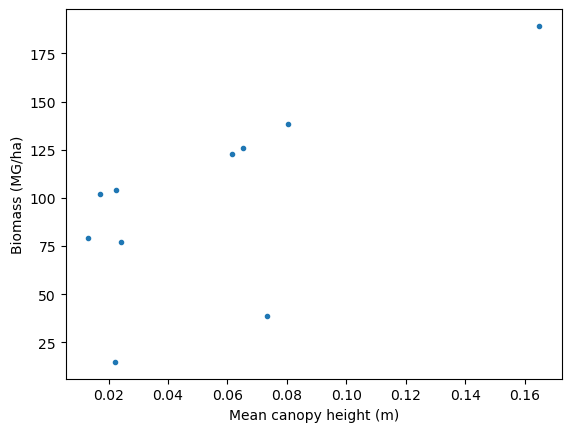

In [20]:

# read the CHM geotiff in to RAM
chmName='data/ALS/merged_CHM_10m.tif'
chmFile=rasterio.open(chmName)
chmData=chmFile.read(1)

# find the top left corner coordinate
xOrigin=chmFile.transform[2]
yOrigin=chmFile.transform[5]

# get a list of pixel coordinates for the ground plots
xInds=np.array((x-xOrigin)/chmFile.res[0],dtype=int)
yInds=np.array((yOrigin-y)/chmFile.res[1],dtype=int)

# extract the values to make a new array of mean canopy height
meanCH=chmData[xInds,yInds]

# add some code to make a scatterplot of biomass (agbd) against mean canopy height (meanCH)
plt.plot(meanCH,agbd,'.')
plt.ylabel('Biomass (MG/ha)')
plt.xlabel('Mean canopy height (m)')

#plt.show()

Now you have viewed the data and chosen an appopriate mathamatical model (was it linear, loigarithmic etc.?), you can perform linear regression within python to get the equation for your biomass model. 

The code below shows you can example of fitting a line of best fit to two random datasets, and calculates the correlation (Pearson's $r$ value). We saw `linregress` last week, but not `pearsonr`. However, Pearson's $r$ is the correlation between $x$ and $y$, which is also returned by `linregress`. The difference is that `pearsonr` returns its value *and significance*. You may recall $R^2$, the *coefficient of determination*, from learning about regression in high school. Despite the upper/lower case difference, in linear regression, $R^2$ is the square of Pearson's $r$.

**Modify that code to find the equation needed to predict biomass from mean canopy height and report the strength of the correlation.**

In [ ]:

# packages to do linear regression and Pearson's correlation
from scipy.stats import linregress, pearsonr

# make some fake data
x=np.random.random((20))*100
y=x*3+20+40*(np.random.random((20))-0.5)

# fit a line of best fit. See manual for scipy.stats.linregress for more details
m, c, r, _, _ = linregress(x,y)

print("Line of best fit parameters are m",m,"c",c)

# find the correlation. See manual for scipy.stats.pearsonr
print('Correlation is',pearsonr(x,y))

# the first number returned by pearsonr is the correlation, 99.28% for this fake data


# repeat with the real data
m, c, r, _, _ = linregress(meanCH,agbd)
print("Line of best fit parameters are m",m,"c",c)
print('Correlation is',pearsonr(meanCH,agbd))


## Making the biomass map


Now you have the parameters needed to parameterise a biomass model. **In the cell below, write some code to read in the CHM again (you can reuse the code above) and make a new array of biomass using the model you have just set.** If this was a linear model, the biomass will be:

$biomass = m \times meanCH + c $

You can use ***plt.imshow()*** to print it as an image on your screen, or modify the CHM writing function above to write the biomass raster layer as a new geotiff. Use whichever approach you prefer.

In [ ]:
# read the CHM geotiff in to RAM
chmName='data/ALS/merged_CHM_10m.tif'
data,xOrigin,yOrigin,pixelWidth,pixelHeight,nX,nY=readTiff(chmName)


# apply the model
biomass=m*data+c

# print to screen 
plt.imshow(biomass)
plt.show()         

If there were any large outliers in the CHM, either large positive values due to noise points above ground. or negative due to holes in the data, these can stretch the contrast and make the image above hard to see. These can be removed by either filtering the data (ideally filtering the raw point cloud before making the DSM and DTM), or by adjusting the colour bar on the image. The cell below shows how to filter out all values above 10, for example.

In [ ]:
filtValue=300
filtBiomass=biomass
filtBiomass[biomass>filtValue]=filtValue

# print to screen 
plt.imshow(filtBiomass)
plt.show()         

**Using numpy operations, what is the mean biomass for this valley? What is the maximum biomass for any 10 m pixel?**

In [ ]:
# find the mean and max


meanBiomass=np.mean(biomass)
maxBiomass=np.max(biomass)

print("Mean",round(meanBiomass,2),"t/ha. max",maxBiomass,"t/ha")

## Writing the biomass map to file for reuse

We have displayed the biomass map to creen above. Often we will want to save it for later analysis, either in python or in GIS. We casn do this using GDAL. An example function is given below.

In [ ]:
def writeTiff(inName,outName,data):
    '''A function to read a tiff and then write a new tiff with the same geolocation but different properties'''

    # get geolocation information from one file (the CHm file in this case)
    inDS=gdal.Open(inName)
    
    # write the output to a file
    OutDriver = gdal.GetDriverByName('GTiff')
    outDS = OutDriver.Create(outName,nX,nY,1,gdal.GDT_Float32 )
    outDS.SetGeoTransform(inDS.GetGeoTransform())
    outDS.SetProjection(inDS.GetProjection()) # copy projection info
    outDS.GetRasterBand(1).WriteArray(data)  # write image to the raster
    outDS.FlushCache()                     # write to disk
    outDS = None
    
    print('Written to',outName)
    return



# set a filename
outName='biomass.tif'

# write the data, matching the geolocation of the CHM
writeTiff(chmName,outName,biomass)

## A comment on automation


As you have seen above, making a biomass map with Python requires quite a few functions, some using some unintuitive aspects of the language. However, you now have a workflow to process a set of geotiff tiles through to biomass. You can rerun the whole workflow by pressing the double arrow button at the top of the screen.

You can do this for any data by downloading new tiles and putting them in the directories above. You can make adjustments to the workflow instructions (eg. change the resolution you do the calculation at, or add in an extra bit of processing) and then reurn everything with a single button.

## Visually assessing the results

You have now produced a biomass map entirely in Python. Whilst python does allow you to make plots of maps and to calculate summary statistics, it can be clunky to assess one map against other. For that task, GIS allows you to more interactively work with the data.

Download the biomass map you have made (go to the tab to the left of this, navigate to the map and tick and download it). Load this in to QGIS (either on your own computer or Apps.ed) and overlay it with a Bing aerial image.

Can you see any obvious errors in the biomass map? Can you see a way to limit your analysis to a particular estate or a particular land type?